<a href="https://colab.research.google.com/github/Devanshu0502/NFL-Big-Data-Bowl-2023/blob/main/big_data_bowl_coverage_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, PReLU,CELU
from torch.utils.data import DataLoader, TensorDataset
import io
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GroupKFold
import seaborn as sns
import time
from sklearn.manifold import TSNE

pd.options.display.max_columns = 100

In [2]:
pff_data = pd.read_csv('/content/drive/MyDrive/nfl-big-data-bowl-2023/pffScoutingData.csv')


plays = pd.read_csv('/content/drive/MyDrive/nfl-big-data-bowl-2023/plays.csv')


players = pd.read_csv('/content/drive/MyDrive/nfl-big-data-bowl-2023/players.csv')

bdb_data = []
for week in range(1,9):

    bdb_data.append(pd.read_csv('/content/drive/MyDrive/nfl-big-data-bowl-2023/week' + str(week) + '.csv'))
bdb_data = pd.concat(bdb_data)

pff_data = pff_data[(pff_data['gameId'] != 2021101700 ) & (pff_data['playId'] != 2372)]
plays = plays[(plays['gameId'] != 2021101700 ) & (plays['playId'] != 2372)]
bdb_data = bdb_data[(bdb_data['gameId'] != 2021101700 ) & (bdb_data['playId'] != 2372)]


bdb_data = bdb_data.dropna(subset=['x','y'])
bdb_data = pd.merge(bdb_data,plays[['gameId','playId','pff_passCoverage']],on=['gameId','playId'],how='left')
bdb_data['gameId'] = bdb_data['gameId'].astype(str)
bdb_data['playId'] = bdb_data['playId'].astype(str)
bdb_data['game_play_id'] = bdb_data['gameId']+ '_' + bdb_data['playId']

#This code is used to convert the coordinates of players to relative coordinates to the ball in the first frame of the game play
#The x_ball and y_ball are the coordinates of the ball in the first frame of the game play
#x and y are the coordinates of the players in the first frame of the game play
#The code is used to convert the x and y to the relative coordinates to the ball in the first frame of the game play
#The function names are: bdb_data_snap, ball_snap_location, bdb_data_snap
#The variable names are: x_ball, y_ball, x, y

bdb_data_snap = bdb_data[bdb_data['frameId'] == 25].reset_index()
bdb_data_snap.loc[bdb_data_snap['playDirection'] == 'left','x'] = 120-bdb_data_snap['x']
bdb_data_snap.loc[bdb_data_snap['playDirection'] == 'left','y'] = 53.33-bdb_data_snap['y']

bdb_data_snap.loc[bdb_data_snap['playDirection'] == 'left','s'] = -bdb_data_snap['s']
bdb_data_snap.loc[bdb_data_snap['playDirection'] == 'left','a'] = -bdb_data_snap['a']
ball_snap_location = bdb_data_snap[bdb_data_snap['team'] == 'football']
bdb_data_snap = pd.merge(bdb_data_snap,ball_snap_location[['game_play_id','x','y']],on=['game_play_id'],suffixes=('','_ball'),how='left')
bdb_data_snap['x'] = bdb_data_snap['x'] - bdb_data_snap['x_ball']
bdb_data_snap['y'] = bdb_data_snap['y'] - bdb_data_snap['y_ball']

In [3]:
bdb_data_snap['x_dir'] = np.cos(bdb_data_snap['dir']*math.pi/180)
bdb_data_snap['y_dir'] = np.sin(bdb_data_snap['dir']*math.pi/180)

bdb_data_snap['x_s'] = bdb_data_snap['s'] * bdb_data_snap['x_dir']
bdb_data_snap['y_s'] = bdb_data_snap['s'] * bdb_data_snap['y_dir']

In [4]:
pff_data['game_play_id'] = pff_data['gameId'].astype(str)+ '_' + pff_data['playId'].astype(str)
pff_data = pd.merge(pff_data,bdb_data_snap[['game_play_id','nflId','x','y','x_s','y_s','pff_passCoverage']],on=['game_play_id','nflId'],how='left')
pff_data =pff_data.dropna(subset=['x'])
pff_data['off'] = pff_data['pff_role'].isin(['Pass','Pass Block','Pass Route']).astype(int)

In [5]:
off_id_set = set(pff_data[pff_data['off'] == 1]['game_play_id'].unique())
defender_id_set = set(pff_data[pff_data['off'] == 0]['game_play_id'].unique())

valid_id_set = list(set.intersection(off_id_set,defender_id_set))

In [6]:
pff_data = pff_data[pff_data['game_play_id'].isin(valid_id_set)]

In [7]:
def create_features(df):
    off_x = np.array(df[(df.off == 1) ].groupby('game_play_id')['x'].apply(np.array))
    def_x = np.array(df[(df.off == 0) ].groupby('game_play_id')['x'].apply(np.array))
    off_y = np.array(df[(df.off == 1) ].groupby('game_play_id')['y'].apply(np.array))
    def_y = np.array(df[(df.off == 0) ].groupby('game_play_id')['y'].apply(np.array))
    off_sx = np.array(df[(df.off == 1)].groupby('game_play_id')['x_s'].apply(np.array))
    def_sx = np.array(df[(df.off == 0) ].groupby('game_play_id')['x_s'].apply(np.array))
    off_sy = np.array(df[(df.off == 1)].groupby('game_play_id')['y_s'].apply(np.array))
    def_sy = np.array(df[(df.off == 0) ].groupby('game_play_id')['y_s'].apply(np.array))

    player_vector = []
    for play in range(len(off_x)):

        player_feat = player_feature(off_x[play],def_x[play],off_y[play],def_y[play],off_sx[play],def_sx[play],
                                     off_sy[play],def_sy[play])
        player_vector.append(player_feat)

    return np.array(player_vector)

def player_feature(off_x,def_x,off_y,def_y,off_sx,def_sx,off_sy,def_sy):
    if(len(off_x) > 11):
        off_x = off_x[:11]
        off_y = off_y[:11]
        off_sx = off_sx[:11]
        off_sy = off_sy[:11]

    if(len(def_x)> 11):
        def_x = def_x[:11]
        def_y = def_y[:11]
        def_sx = def_sx[:11]
        def_sy = def_sy[:11]

    if(len(off_x)<11):
        off_x = np.pad(off_x,(11-len(off_x),0), 'mean' )
        off_y = np.pad(off_y,(11-len(off_y),0), 'mean' )
        off_sx = np.pad(off_sx,(11-len(off_sx),0), 'mean' )
        off_sy = np.pad(off_sy,(11-len(off_sy),0), 'mean' )
    if(len(def_x)<11):
        def_x = np.pad(def_x,(11-len(def_x),0), 'mean' )
        def_y = np.pad(def_y,(11-len(def_y),0), 'mean' )
        def_sx = np.pad(def_sx,(11-len(def_sx),0), 'mean' )
        def_sy = np.pad(def_sy,(11-len(def_sy),0), 'mean' )


    dist_def_off_x = def_x.reshape(-1,1)-off_x.reshape(1,-1)
    dist_def_off_sx = def_sx.reshape(-1,1)-off_sx.reshape(1,-1)
    dist_def_off_y = def_y.reshape(-1,1)-off_y.reshape(1,-1)
    dist_def_off_sy = def_sy.reshape(-1,1)-off_sy.reshape(1,-1)


    off_sx = np.repeat(off_sx,11).reshape(-1,11)
    off_sy = np.repeat(off_sy,11).reshape(-1,11)
    def_sx = np.repeat(def_sx,11).reshape(11,-1)
    def_sy = np.repeat(def_sy,11).reshape(11,-1)
    def_x = np.repeat(def_x,11).reshape(11,-1)
    def_y = np.repeat(def_y,11).reshape(11,-1)
    off_x = np.repeat(off_x,11).reshape(-1,11)
    off_y = np.repeat(off_y,11).reshape(-1,11)

    feats = [dist_def_off_x, dist_def_off_sx, dist_def_off_y, dist_def_off_sy,off_sx,off_sy, def_sx, def_sy, def_x, def_y]

    return np.stack(feats)

In [8]:
x = create_features(pff_data)

In [9]:
x.shape

(8443, 10, 11, 11)

In [10]:
def scaling(feats, sctype="standard"):
    v1 = []
    v2 = []
    for i in range(feats.shape[1]):
        feats_ = feats[:, i, :]
        if sctype == "standard":
            mean_ = np.mean(feats_)
            std_ = np.std(feats_)
            feats[:, i, :] -= mean_
            feats[:, i, :] /= std_
            v1.append(mean_)
            v2.append(std_)
        elif sctype == "minmax":
            max_ = np.max(feats_)
            min_ = np.min(feats_)
            feats[:, i, :] = (feats_ - min_) / (max_ - min_)
            v1.append(max_)
            v2.append(min_)

    return feats, v1, v2

x, sc_mean, sc_std = scaling(x)

In [11]:
num_feature = 10
num_classes = len(pff_data['pff_passCoverage'].unique())
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(num_feature , 64, kernel_size=3, stride=1, padding=1),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1),

            nn.Flatten(),
        )
        # Flatten the encoder output from [-1, 100] to [-1,4]
        self.embedding_layer = nn.Linear(4, 4)


        # Decoder layers
        self.decoder = nn.Sequential(
            # Unflatten the encoder output from [-1, 20] to [-1, 100] and reshape to [-1, 4, 5, 5]
            nn.Linear(4, 4),
            nn.Unflatten(1, (4, 1, 1)),

            nn.ConvTranspose2d(4, 16, kernel_size=3, stride=2, padding=1, output_padding=1),


            nn.ConvTranspose2d(16, 40, kernel_size=3, stride=2, padding=1, output_padding=1),


            nn.ConvTranspose2d(40, num_feature , kernel_size=6, stride=2, padding=1, output_padding=1),


            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.embedding_layer(x)
        x = self.decoder(x)
        return x

In [12]:
!pip install torchsummary

In [13]:
from torchsummary import summary

device = "cpu"
model = Autoencoder()
model.to(device)
summary(model, (num_feature ,11,11))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 11, 11]           5,824
         MaxPool2d-2             [-1, 64, 5, 5]               0
            Conv2d-3             [-1, 32, 5, 5]          18,464
         MaxPool2d-4             [-1, 32, 2, 2]               0
            Conv2d-5             [-1, 16, 2, 2]           4,624
         MaxPool2d-6             [-1, 16, 1, 1]               0
            Conv2d-7              [-1, 4, 1, 1]             580
           Flatten-8                    [-1, 4]               0
            Linear-9                    [-1, 4]              20
           Linear-10                    [-1, 4]              20
        Unflatten-11              [-1, 4, 1, 1]               0
  ConvTranspose2d-12             [-1, 16, 2, 2]             592
  ConvTranspose2d-13             [-1, 40, 4, 4]           5,800
  ConvTranspose2d-14           [-1, 10,

In [14]:
# Record fc1 layer output with forward hook

def hook_fn(module, input, output, weight):
    weight.append(output)

In [15]:
temp_df = pff_data.groupby('game_play_id').first().reset_index()

y_coverage = temp_df['pff_passCoverage'].astype('category').cat.codes.values

In [16]:
device = "cpu"
epochs = 20
SEED = 71

EXP_ID = "coverage_classify"
BATCH_SIZE = 128

from sklearn.model_selection import GroupKFold

folds = GroupKFold(n_splits=5).split(y_coverage, groups=temp_df['gameId'].values)


# if(model != None):
#     del model
#     torch.cuda.empty_cache()

train_dataset = TensorDataset(torch.tensor(x, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

#     val_dataset = TensorDataset(torch.tensor(X[val_idx], dtype=torch.float32), torch.tensor(y_coverage[val_idx], dtype=torch.float32))
#     val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


model = Autoencoder()

model.embedding_layer.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, weight))
model.to(device)
BATCH_SIZE = 1024
num_steps = len(x) // BATCH_SIZE
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,epochs=epochs+1,steps_per_epoch=2*num_steps)
best_score = 999

for epoch in range(1, epochs + 1):
    weight = []
    print(epoch)
    start_time = time.time()
    running_loss = 0.0
    for data in train_loader:
        # Get the input data and reshape it to match the input shape of the autoencoder
        inputs = torch.Tensor(x)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()



    print('Epoch [%d/%d], Loss: %.4f'
  % (epoch+1, epochs, running_loss/len(train_loader)))
    print(time.time()-start_time)
    # if score < best_score:
    #     best_score = score
    #     best_epoch = epoch
torch.save(model.state_dict(), '{}.pth'.format(EXP_ID))

1
Epoch [2/20], Loss: -0.0212
175.83726501464844
2
Epoch [3/20], Loss: -0.1554
171.34750723838806
3
Epoch [4/20], Loss: -0.1990
172.9785294532776
4
Epoch [5/20], Loss: -0.2625
182.3866832256317
5
Epoch [6/20], Loss: -0.4053
177.87888097763062
6
Epoch [7/20], Loss: -0.5179
177.54274153709412
7
Epoch [8/20], Loss: -0.7241
174.93147349357605
8
Epoch [9/20], Loss: -0.8103
177.51155519485474
9
Epoch [10/20], Loss: -0.8380
177.43004989624023
10
Epoch [11/20], Loss: -0.8591
178.1529622077942
11
Epoch [12/20], Loss: -0.8763
184.19548964500427
12
Epoch [13/20], Loss: -0.8878
178.42115092277527
13
Epoch [14/20], Loss: -0.8952
178.1555621623993
14
Epoch [15/20], Loss: -0.9000
184.22770500183105
15
Epoch [16/20], Loss: -0.9032
177.31037211418152
16
Epoch [17/20], Loss: -0.9055
178.77904605865479
17
Epoch [18/20], Loss: -0.9071
176.87547945976257
18
Epoch [19/20], Loss: -0.9083
184.14314937591553
19
Epoch [20/20], Loss: -0.9092
179.55954337120056
20
Epoch [21/20], Loss: -0.9101
178.42368531227112


In [17]:
weight = torch.cat(weight, dim=0).cpu().detach().numpy()

In [18]:
coverage_type = temp_df['pff_passCoverage'].astype('category').cat.categories

In [19]:
coverage_type

Index(['2-Man', 'Bracket', 'Cover-0', 'Cover-1', 'Cover-2', 'Cover-3',
       'Cover-6', 'Goal Line', 'Miscellaneous', 'Prevent', 'Quarters',
       'Red Zone'],
      dtype='object')

In [20]:
def plot_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42,perplexity=50)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    for i,label in enumerate(np.unique(labels)):
        mask = (labels == label)
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=coverage_type[i], alpha=0.5)
    plt.legend()
    plt.show()

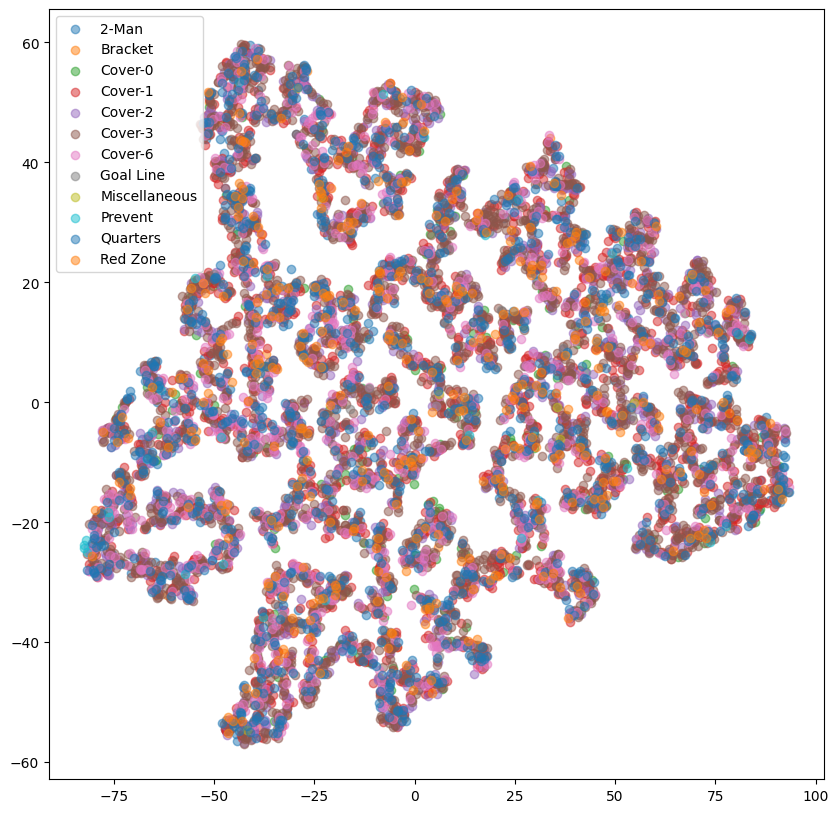

In [21]:
plot_embeddings(weight[:x.shape[0]], y_coverage)